In [1]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import datetime as dt
import talib
from tqdm import tqdm
import colorama as col
from bt import *
from sklearn.preprocessing import MinMaxScaler
from pycaret.classification import *

Importing Librairies...


In [2]:
%%time
##### Chargement de la base
base = pd.read_csv('Base_Clean/EURUSDH1.csv')

##### On fixe la date en index sous forme de Timestamp
base.set_index(pd.to_datetime(base.Date),drop=True,inplace=True)

###### On drop les colonnes inutiles
base = base.drop(['Date','Total'],axis=1)

##### On enlève les jours correspondant au samedi et au dimanche
base['WE'] = np.where(((base.index.weekday == 5) | (base.index.weekday == 6)),None,base.index.weekday)
base = base.dropna()
base = base.drop(['WE'],axis=1)


CPU times: user 173 ms, sys: 39.4 ms, total: 212 ms
Wall time: 215 ms


In [3]:
base.index[0],base.index[-1]

(Timestamp('2010-11-23 00:00:00'), Timestamp('2020-11-23 23:00:00'))

In [4]:
%%time
_year_bottom = pd.to_datetime('2011-01-01 16:00:00')
_year_top = pd.to_datetime('2015-12-31 16:00:00') #2020-11-23 16:00:00

df = base[(base.index>=_year_bottom)&(base.index<=_year_top)]

CPU times: user 3.37 ms, sys: 2.14 ms, total: 5.5 ms
Wall time: 4.75 ms


In [5]:
df['HiWin'] = df.High.rolling(10).max()
df['LoWin'] = df.Low.rolling(10).min()
df['JyssOscUp'] = ((df.HiWin-df.HiWin.shift(2))/df.HiWin.shift(2))*1000
df['JyssOscUpSD'] = df.JyssOscUp.rolling(20).std()
df['JyssOscDwn'] = ((df.LoWin-df.LoWin.shift(2))/df.LoWin.shift(2))*1000
df['JyssOscDwnSD'] = df.JyssOscDwn.rolling(20).std()
df['TriggerBull'] = (df.HiWin - df.HiWin.shift(2)) * 1000
df['TriggerBear'] = (df.LoWin - df.LoWin.shift(2)) * 1000
df['Trigger'] = np.where((df.LoWin - df.LoWin.shift(9) == 0),1,np.where((df.HiWin - df.HiWin.shift(9) == 0 ),1,0))

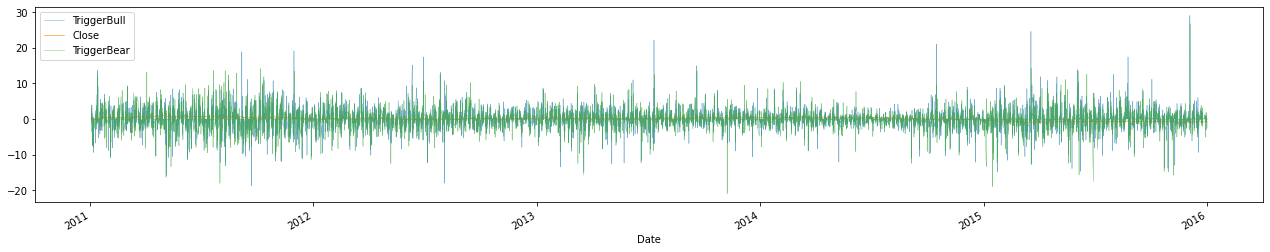

In [6]:
scaler = MinMaxScaler((-1,1))
df.TriggerBull.plot(figsize=(22,4),linewidth=0.5,alpha=0.6)
plt.plot(df.Close.index,scaler.fit_transform(df.Close.values.reshape(-1,1)),label='Close',alpha=0.8,linewidth=0.7)
df.TriggerBear.plot(figsize=(22,4),linewidth=0.5,alpha=0.6)

plt.legend()

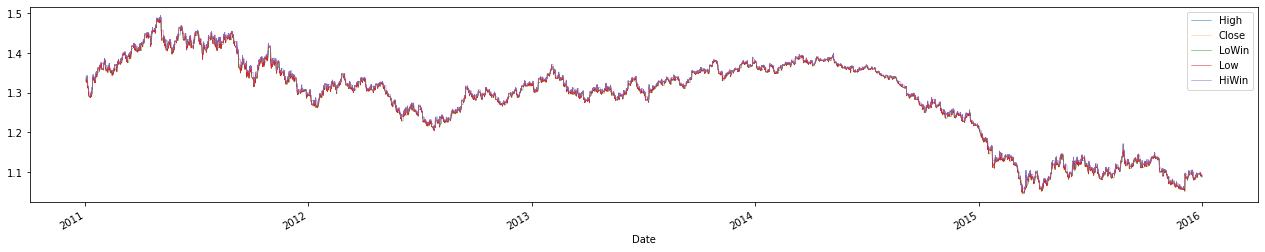

In [7]:
df.High.plot(figsize=(22,4),linewidth=0.5)
df.Close.plot(figsize=(22,4),alpha=0.5,linewidth=0.5)
df.LoWin.plot(figsize=(22,4),linewidth=0.5)
df.Low.plot(figsize=(22,4),linewidth=0.5)
df.HiWin.plot(figsize=(22,4),linewidth=0.5)

plt.legend()

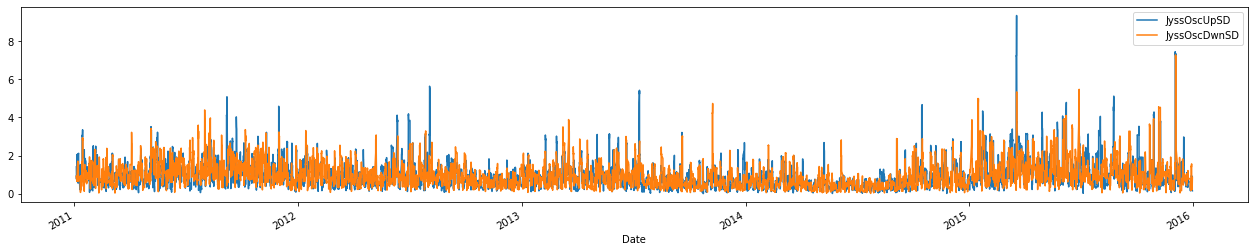

In [8]:
df.JyssOscUpSD.plot(figsize=(22,4))
df.JyssOscDwnSD.plot(figsize=(22,4))
plt.legend()

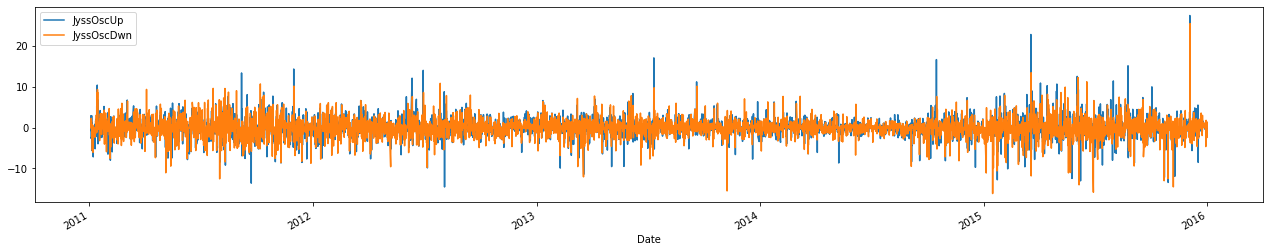

In [9]:
df.JyssOscUp.plot(figsize=(22,4))
df.JyssOscDwn.plot(figsize=(22,4))
plt.legend()

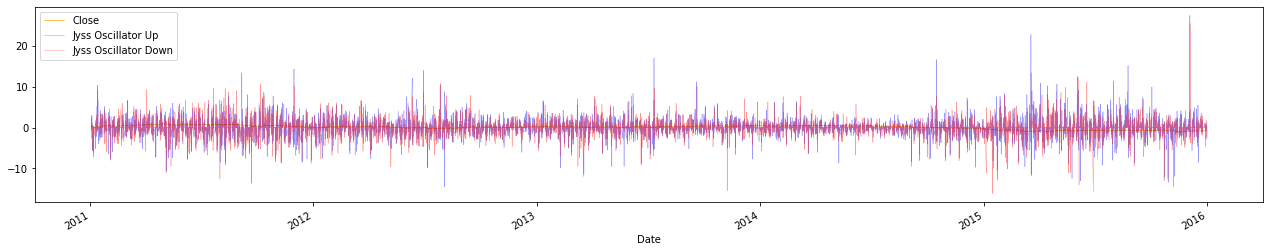

In [10]:

scaler = MinMaxScaler((-1,1))
plt.plot(df.Close.index,scaler.fit_transform(df.Close.values.reshape(-1,1)),label='Close',alpha=0.9,linewidth=0.7,color='orange')
df.JyssOscUp.plot(figsize=(22,4),label='Jyss Oscillator Up',alpha=0.4,linewidth=0.5,color='b')
df.JyssOscDwn.plot(figsize=(22,4),label='Jyss Oscillator Down',alpha=0.4,linewidth=0.5,color='r')
#df.JyssOscUpSD.plot(label='Std du Jyss Oscillator Up',alpha=0.7,linewidth=0.5)
#df.JyssOscDwnSD.plot(label='Std du Jyss Oscillator Down',alpha=0.7,linewidth=0.5)
#plt.plot(df.TriggerBull.index,scaler.fit_transform(df.TriggerBull.values.reshape(-1,1)),label='Trigger Bull',alpha=0.7,linewidth=0.5)
#plt.plot(df.TriggerBear.index,scaler.fit_transform(df.TriggerBear.values.reshape(-1,1)),label='Trigger Bear',alpha=0.7,linewidth=0.5)
plt.legend()
#plt.savefig('JyssOscillator',dpi=1000)


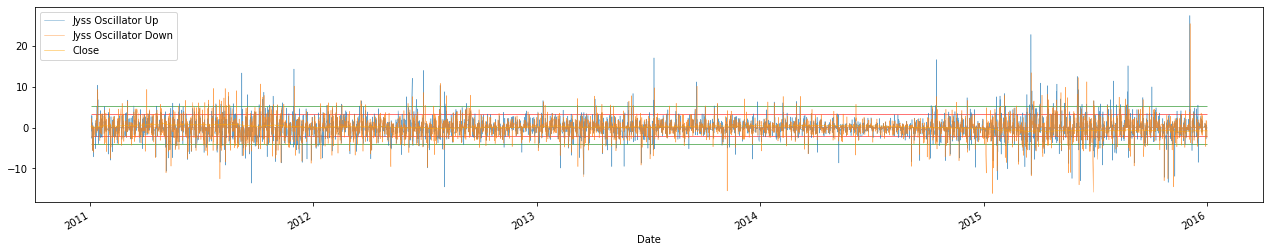

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((-1,1))
df.JyssOscUp.plot(figsize=(22,4),label='Jyss Oscillator Up',alpha=0.7,linewidth=0.5)
df.JyssOscDwn.plot(figsize=(22,4),label='Jyss Oscillator Down',alpha=0.7,linewidth=0.5)
plt.plot(df.Close.index,scaler.fit_transform(df.Close.values.reshape(-1,1)),label='Close',color='orange',alpha=0.7,linewidth=0.6)
plt.hlines(xmin=df.index[0],xmax=df.index[-1],y=4*df.JyssOscUp.std(),color='green',alpha=0.9,linewidth=0.6)
plt.hlines(xmin=df.index[0],xmax=df.index[-1],y=-3*df.JyssOscUp.std(),color='green',alpha=0.9,linewidth=0.6)
plt.hlines(xmin=df.index[0],xmax=df.index[-1],y=2.5*df.JyssOscUp.std(),color='red',alpha=0.9,linewidth=0.6)
plt.hlines(xmin=df.index[0],xmax=df.index[-1],y=-1.5*df.JyssOscUp.std(),color='red',alpha=0.9,linewidth=0.6)
plt.legend()

In [12]:
'''df['Signal'] = np.where(\
    ((df.Close <= 1.01*df.LoWin)&(df.JyssOsc <= -4*df.JyssOscSD)),1,\
        np.where(\
            ((df.Close >= 0.99*df.HiWin)&(df.JyssOsc >= 4*df.JyssOscSD)),-1,0)
)
df['SignalClose'] = np.where(\
    ((df.Close >= 0.99*df.HiWin)&(df.JyssOsc <= -3*df.JyssOscSD)),1,\
        np.where(\
            ((df.Close <= 1.01*df.LoWin)&(df.JyssOsc >= 3*df.JyssOscSD)),-1,0)
)'''

"df['Signal'] = np.where(    ((df.Close <= 1.01*df.LoWin)&(df.JyssOsc <= -4*df.JyssOscSD)),1,        np.where(            ((df.Close >= 0.99*df.HiWin)&(df.JyssOsc >= 4*df.JyssOscSD)),-1,0)\n)\ndf['SignalClose'] = np.where(    ((df.Close >= 0.99*df.HiWin)&(df.JyssOsc <= -3*df.JyssOscSD)),1,        np.where(            ((df.Close <= 1.01*df.LoWin)&(df.JyssOsc >= 3*df.JyssOscSD)),-1,0)\n)"

In [13]:
df['Signal'] = np.where(\
    ((df.Close <= 1.01*df.LoWin)&(df.JyssOscUp <= -4*df.JyssOscUpSD)),1,\
        np.where(\
            ((df.Close >= 0.99*df.HiWin)&(df.JyssOscDwn >= 4*df.JyssOscDwnSD)),-1,0)
)
df['SignalClose'] = np.where(\
    ((df.Close >= 0.99*df.HiWin)&(df.JyssOscDwn <= -3*df.JyssOscDwnSD)),1,\
        np.where(\
            ((df.Close <= 1.01*df.LoWin)&(df.JyssOscUp >= 3*df.JyssOscUpSD)),-1,0)
)

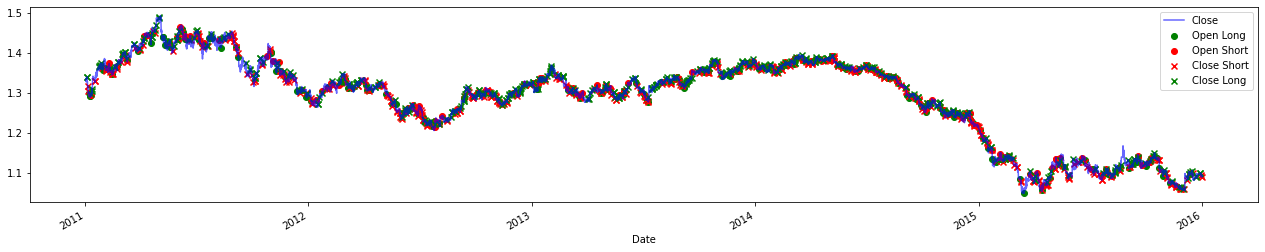

In [14]:
df.Close.plot(figsize=(22,4),label='Close',color='b',alpha=0.6)

plt.scatter(x=df[df.Signal==1].index,y=df[df.Signal==1].Close,color='green',marker='o',label='Open Long')

plt.scatter(x=df[df.Signal==-1].index,y=df[df.Signal==-1].Close,color='red',marker='o',label='Open Short')

plt.scatter(x=df[df.SignalClose==1].index,y=df[df.SignalClose==1].Close,color='red',marker='x',label='Close Short')

plt.scatter(x=df[df.SignalClose==-1].index,y=df[df.SignalClose==-1].Close,color='green',marker='x',label='Close Long')

plt.legend()

In [15]:
_nb_bougie_exit = 96000000
_trigger_reengage = 0
_trigger_target = 1
_trigger_invers = 1
_trigger_sl = 0
_verbose = 0
_cash_ini = 200000
_rate = 1
x = 'EUR/USD'
_target = 0.006
_exposure = 3
_size = 50000
_sl = 0.002
TRACKER = bt_cond(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl)

Librairies imported

Début des opérations horodatée à 2020-12-15 13:40:45.423116

Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 30857/30857 [00:02<00:00, 15129.53it/s]
 Pour le ticker  EUR/USD 
 
Les gains faramineux s'élèvent à : $  11196.5 !. En  181   transactions.
 
Nbre de winners : 130 
 
Nbre de loosers : 51 
Temps d'excution du BT 0:00:08.285552
 EUR/USD  results 
 Tested Period 2011-01-01 16:00:00  à 2015-12-31 16:00:00 
 Total Number of trades 181 
Started Cash : 50000
P&L  in currency:  11196.5$ 
P&L in %:  5.6% 
Average trade duration 70.39
# Winners  130.0
# Loosers  51.0
Cumulated gains 38576.0
Cumulated losses -27379.5
 PROFIT FACTOR :  1.41 
 Winners Ratio : 71.82 % 
Average Winners 296.74
% Average Winners 0.15
Average Loosers -536.85
% Average Loosers -0.27
Average pnl 61.86
% Average pnl 0.03
Number of opened trades 181
Number of closed trades 181
Max Exposure 1 x  

In [16]:
len(TRACKER)

143

In [17]:
%%time
scaler = MinMaxScaler((0,1))
df_2 = df.copy()
df_2['RSI2'] = talib.RSI(df_2.Close,timeperiod=2)
df_2['MMA200'] = talib.EMA(df_2.Close,timeperiod=80)
upper, middle, lower = talib.BBANDS(df_2.Close, timeperiod=10, nbdevup=2, nbdevdn=2)
df_2['SBVol'] = upper - lower

#df_2 = df_2.drop(['SignalClose'],axis=1)

df_2.rename(columns = {'Signal':'SigO4bt'}, inplace = True)
#df_2.rename(columns = {'SignalClose':'SigC4bt'}, inplace = True)
df_2 = df_2.drop(['SignalClose'],axis=1)
SIGNAL = []
SIGNAL = [1 if ((df_2['SigO4bt'][i] != 0) & (df_2.index[i] in TRACKER)) else 0 for i in tqdm(range(len(df_2)))]
#SIGNALC = []
#SIGNALC = [1 if ((df_2['SigC4bt'][i] != 0) & (df_2.index[i] in TRACKER)) else 0 for i in tqdm(range(len(df_2)))]
df_2['Signal'] = SIGNAL

#df_2['SignalClose'] = SIGNALC

#df_2 = df_2[['HiWin','LoWin','JyssOscUp','JyssOscUpSD','JyssOscDwn','JyssOscDwnSD','TriggerBull',\
#                'TriggerBear','Trigger','SigO4bt','Signal']]
df_2 = df_2.dropna()

df_2 = df_2.sort_index(axis=1)
#df_2 = scaler.fit_transform(df_2.values) 

100%|██████████| 30887/30887 [00:01<00:00, 29395.44it/s]CPU times: user 1.07 s, sys: 17.4 ms, total: 1.09 s
Wall time: 1.09 s



In [19]:
%%time
# check pycaret version
import pycaret
from pycaret.classification import setup
from pycaret.classification import compare_models

print('PyCaret: %s' % pycaret.__version__)

# setup the dataset
grid = setup(data=df_2.sort_index(axis=1), target='Signal', html=False, silent=True, verbose=True, feature_selection = True,feature_selection_threshold=0.7,remove_multicollinearity = True, multicollinearity_threshold = 0.6)

# evaluate models and compare models
best = compare_models(sort='Prec.')

# report the best model
print(best)

PyCaret: 2.2.0
Setup Succesfully Completed!


Description             Value
0                               session_id              2711
1                                   Target            Signal
2                              Target Type            Binary
3                            Label Encoded        0: 0, 1: 1
4                            Original Data       (30808, 26)
5                           Missing Values             False
6                         Numeric Features                23
7                     Categorical Features                 2
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set        (21565, 7)
12                    Transformed Test Set         (9243, 7)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU             False
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              8a1a
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity              True
43             Multicollinearity Threshold               0.6
44                              Clustering             False
45                    Clustering Iteration              None
46                     Polynomial Features             False
47                       Polynomial Degree              None
48                    Trignometry Features             False
49                    Polynomial Threshold              None
50                          Group Features             False
51                       Feature Selection              True
52            Features Selection Threshold               0.7
53                     Feature Interaction             False
54                           Feature Ratio             False
55                   Interaction Threshold              None
56                           Fix Imbalance             False
57                    Fix Imbalance Method             SMOTE

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
lr  Logistic Regression    0.9956  0.9981  0.3178  0.5278  0.3774  0.3755   

       MCC  TT (Sec)  
lr  0.3964     1.129

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
lr      Logistic Regression    0.9956  0.9981  0.3178  0.5278  0.3774  0.3755   
knn  K Neighbors Classifier    0.9954  0.6706  0.0000  0.0000  0.0000 -0.0003   

        MCC  TT (Sec)  
lr   0.3964     1.129  
knn -0.0004     0.150

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
lr      Logistic Regression    0.9956  0.9981  0.3178  0.5278  0.3774  0.3755   
nb              Naive Bayes    0.9956  0.9978  1.0000  0.5228  0.6813  0.6793   
knn  K Neighbors Classifier    0.9954  0.6706  0.0000  0.0000  0.0000 -0.0003   

        MCC  TT (Sec)  
lr   0.3964     1.129  
nb   0.7184     0.033  
knn -0.0004     0.150

Model  Accuracy     AUC  Recall   Prec.      F1  \
lr        Logistic Regression    0.9956  0.9981  0.3178  0.5278  0.3774   
nb                Naive Bayes    0.9956  0.9978  1.0000  0.5228  0.6813   
dt   Decision Tree Classifier    0.9953  0.7200  0.4422  0.5087  0.4504   
knn    K Neighbors Classifier    0.9954  0.6706  0.0000  0.0000  0.0000   

      Kappa     MCC  TT (Sec)  
lr   0.3755  0.3964     1.129  
nb   0.6793  0.7184     0.033  
dt   0.4481  0.4604     0.046  
knn -0.0003 -0.0004     0.150

Model  Accuracy     AUC  Recall   Prec.      F1  \
lr        Logistic Regression    0.9956  0.9981  0.3178  0.5278  0.3774   
nb                Naive Bayes    0.9956  0.9978  1.0000  0.5228  0.6813   
dt   Decision Tree Classifier    0.9953  0.7200  0.4422  0.5087  0.4504   
svm       SVM - Linear Kernel    0.9953  0.0000  0.1833  0.4488  0.2260   
knn    K Neighbors Classifier    0.9954  0.6706  0.0000  0.0000  0.0000   

      Kappa     MCC  TT (Sec)  
lr   0.3755  0.3964     1.129  
nb   0.6793  0.7184     0.033  
dt   0.4481  0.4604     0.046  
svm  0.2245  0.2614     0.072  
knn -0.0003 -0.0004     0.150

Model  Accuracy     AUC  Recall   Prec.      F1  \
lr          Logistic Regression    0.9956  0.9981  0.3178  0.5278  0.3774   
nb                  Naive Bayes    0.9956  0.9978  1.0000  0.5228  0.6813   
dt     Decision Tree Classifier    0.9953  0.7200  0.4422  0.5087  0.4504   
svm         SVM - Linear Kernel    0.9953  0.0000  0.1833  0.4488  0.2260   
ridge          Ridge Classifier    0.9949  0.0000  0.6200  0.4099  0.4183   
knn      K Neighbors Classifier    0.9954  0.6706  0.0000  0.0000  0.0000   

        Kappa     MCC  TT (Sec)  
lr     0.3755  0.3964     1.129  
nb     0.6793  0.7184     0.033  
dt     0.4481  0.4604     0.046  
svm    0.2245  0.2614     0.072  
ridge  0.4166  0.4590     0.032  
knn   -0.0003 -0.0004     0.150

Model  Accuracy     AUC  Recall   Prec.      F1  \
lr          Logistic Regression    0.9956  0.9981  0.3178  0.5278  0.3774   
nb                  Naive Bayes    0.9956  0.9978  1.0000  0.5228  0.6813   
rf     Random Forest Classifier    0.9953  0.9975  0.3589  0.5106  0.4035   
dt     Decision Tree Classifier    0.9953  0.7200  0.4422  0.5087  0.4504   
svm         SVM - Linear Kernel    0.9953  0.0000  0.1833  0.4488  0.2260   
ridge          Ridge Classifier    0.9949  0.0000  0.6200  0.4099  0.4183   
knn      K Neighbors Classifier    0.9954  0.6706  0.0000  0.0000  0.0000   

        Kappa     MCC  TT (Sec)  
lr     0.3755  0.3964     1.129  
nb     0.6793  0.7184     0.033  
rf     0.4013  0.4162     0.572  
dt     0.4481  0.4604     0.046  
svm    0.2245  0.2614     0.072  
ridge  0.4166  0.4590     0.032  
knn   -0.0003 -0.0004     0.150

Model  Accuracy     AUC  Recall   Prec.  \
lr                 Logistic Regression    0.9956  0.9981  0.3178  0.5278   
nb                         Naive Bayes    0.9956  0.9978  1.0000  0.5228   
rf            Random Forest Classifier    0.9953  0.9975  0.3589  0.5106   
dt            Decision Tree Classifier    0.9953  0.7200  0.4422  0.5087   
svm                SVM - Linear Kernel    0.9953  0.0000  0.1833  0.4488   
ridge                 Ridge Classifier    0.9949  0.0000  0.6200  0.4099   
qda    Quadratic Discriminant Analysis    0.1035  0.0599  0.9000  0.0040   
knn             K Neighbors Classifier    0.9954  0.6706  0.0000  0.0000   

           F1   Kappa     MCC  TT (Sec)  
lr     0.3774  0.3755  0.3964     1.129  
nb     0.6813  0.6793  0.7184     0.033  
rf     0.4035  0.4013  0.4162     0.572  
dt     0.4504  0.4481  0.4604     0.046  
svm    0.2260  0.2245  0.2614     0.072  
ridge  0.4183  0.4166  0.4590     0.032  
qda    0.0080 -0.0002 -0.0002     0.058  
knn    0.0000 -0.0003 -0.0004     0.150

Model  Accuracy     AUC  Recall   Prec.  \
lr                 Logistic Regression    0.9956  0.9981  0.3178  0.5278   
nb                         Naive Bayes    0.9956  0.9978  1.0000  0.5228   
rf            Random Forest Classifier    0.9953  0.9975  0.3589  0.5106   
dt            Decision Tree Classifier    0.9953  0.7200  0.4422  0.5087   
ada               Ada Boost Classifier    0.9953  0.9829  0.4089  0.5028   
svm                SVM - Linear Kernel    0.9953  0.0000  0.1833  0.4488   
ridge                 Ridge Classifier    0.9949  0.0000  0.6200  0.4099   
qda    Quadratic Discriminant Analysis    0.1035  0.0599  0.9000  0.0040   
knn             K Neighbors Classifier    0.9954  0.6706  0.0000  0.0000   

           F1   Kappa     MCC  TT (Sec)  
lr     0.3774  0.3755  0.3964     1.129  
nb     0.6813  0.6793  0.7184     0.033  
rf     0.4035  0.4013  0.4162     0.572  
dt     0.4504  0.4481  0.4604     0.046  
ada    0.4334  0.4312  0.4418     0.573  
svm    0.2260  0.2245  0.2614     0.072  
ridge  0.4183  0.4166  0.4590     0.032  
qda    0.0080 -0.0002 -0.0002     0.058  
knn    0.0000 -0.0003 -0.0004     0.150

Model  Accuracy     AUC  Recall   Prec.  \
lr                 Logistic Regression    0.9956  0.9981  0.3178  0.5278   
nb                         Naive Bayes    0.9956  0.9978  1.0000  0.5228   
rf            Random Forest Classifier    0.9953  0.9975  0.3589  0.5106   
dt            Decision Tree Classifier    0.9953  0.7200  0.4422  0.5087   
ada               Ada Boost Classifier    0.9953  0.9829  0.4089  0.5028   
gbc       Gradient Boosting Classifier    0.9949  0.8700  0.3400  0.4679   
svm                SVM - Linear Kernel    0.9953  0.0000  0.1833  0.4488   
ridge                 Ridge Classifier    0.9949  0.0000  0.6200  0.4099   
qda    Quadratic Discriminant Analysis    0.1035  0.0599  0.9000  0.0040   
knn             K Neighbors Classifier    0.9954  0.6706  0.0000  0.0000   

           F1   Kappa     MCC  TT (Sec)  
lr     0.3774  0.3755  0.3964     1.129  
nb     0.6813  0.6793  0.7184     0.033  
rf     0.4035  0.4013  0.4162     0.572  
dt     0.4504  0.4481  0.4604     0.046  
ada    0.4334  0.4312  0.4418     0.573  
gbc    0.3644  0.3621  0.3804     1.434  
svm    0.2260  0.2245  0.2614     0.072  
ridge  0.4183  0.4166  0.4590     0.032  
qda    0.0080 -0.0002 -0.0002     0.058  
knn    0.0000 -0.0003 -0.0004     0.150

Model  Accuracy     AUC  Recall   Prec.  \
lr                 Logistic Regression    0.9956  0.9981  0.3178  0.5278   
nb                         Naive Bayes    0.9956  0.9978  1.0000  0.5228   
lda       Linear Discriminant Analysis    0.9956  0.9978  1.0000  0.5228   
rf            Random Forest Classifier    0.9953  0.9975  0.3589  0.5106   
dt            Decision Tree Classifier    0.9953  0.7200  0.4422  0.5087   
ada               Ada Boost Classifier    0.9953  0.9829  0.4089  0.5028   
gbc       Gradient Boosting Classifier    0.9949  0.8700  0.3400  0.4679   
svm                SVM - Linear Kernel    0.9953  0.0000  0.1833  0.4488   
ridge                 Ridge Classifier    0.9949  0.0000  0.6200  0.4099   
qda    Quadratic Discriminant Analysis    0.1035  0.0599  0.9000  0.0040   
knn             K Neighbors Classifier    0.9954  0.6706  0.0000  0.0000   

           F1   Kappa     MCC  TT (Sec)  
lr     0.3774  0.3755  0.3964     1.129  
nb     0.6813  0.6793  0.7184     0.033  
lda    0.6813  0.6793  0.7184     0.059  
rf     0.4035  0.4013  0.4162     0.572  
dt     0.4504  0.4481  0.4604     0.046  
ada    0.4334  0.4312  0.4418     0.573  
gbc    0.3644  0.3621  0.3804     1.434  
svm    0.2260  0.2245  0.2614     0.072  
ridge  0.4183  0.4166  0.4590     0.032  
qda    0.0080 -0.0002 -0.0002     0.058  
knn    0.0000 -0.0003 -0.0004     0.150

Model  Accuracy     AUC  Recall   Prec.  \
lr                 Logistic Regression    0.9956  0.9981  0.3178  0.5278   
nb                         Naive Bayes    0.9956  0.9978  1.0000  0.5228   
lda       Linear Discriminant Analysis    0.9956  0.9978  1.0000  0.5228   
rf            Random Forest Classifier    0.9953  0.9975  0.3589  0.5106   
dt            Decision Tree Classifier    0.9953  0.7200  0.4422  0.5087   
ada               Ada Boost Classifier    0.9953  0.9829  0.4089  0.5028   
gbc       Gradient Boosting Classifier    0.9949  0.8700  0.3400  0.4679   
et              Extra Trees Classifier    0.9951  0.9977  0.4189  0.4592   
svm                SVM - Linear Kernel    0.9953  0.0000  0.1833  0.4488   
ridge                 Ridge Classifier    0.9949  0.0000  0.6200  0.4099   
qda    Quadratic Discriminant Analysis    0.1035  0.0599  0.9000  0.0040   
knn             K Neighbors Classifier    0.9954  0.6706  0.0000  0.0000   

           F1   Kappa     MCC  TT (Sec)  
lr     0.3774  0.3755  0.3964     1.129  
nb     0.6813  0.6793  0.7184     0.033  
lda    0.6813  0.6793  0.7184     0.059  
rf     0.4035  0.4013  0.4162     0.572  
dt     0.4504  0.4481  0.4604     0.046  
ada    0.4334  0.4312  0.4418     0.573  
gbc    0.3644  0.3621  0.3804     1.434  
et     0.4291  0.4267  0.4315     0.303  
svm    0.2260  0.2245  0.2614     0.072  
ridge  0.4183  0.4166  0.4590     0.032  
qda    0.0080 -0.0002 -0.0002     0.058  
knn    0.0000 -0.0003 -0.0004     0.150

Model  Accuracy     AUC  Recall   Prec.  \
lr                   Logistic Regression    0.9956  0.9981  0.3178  0.5278   
nb                           Naive Bayes    0.9956  0.9978  1.0000  0.5228   
lda         Linear Discriminant Analysis    0.9956  0.9978  1.0000  0.5228   
rf              Random Forest Classifier    0.9953  0.9975  0.3589  0.5106   
dt              Decision Tree Classifier    0.9953  0.7200  0.4422  0.5087   
ada                 Ada Boost Classifier    0.9953  0.9829  0.4089  0.5028   
gbc         Gradient Boosting Classifier    0.9949  0.8700  0.3400  0.4679   
et                Extra Trees Classifier    0.9951  0.9977  0.4189  0.4592   
svm                  SVM - Linear Kernel    0.9953  0.0000  0.1833  0.4488   
ridge                   Ridge Classifier    0.9949  0.0000  0.6200  0.4099   
qda      Quadratic Discriminant Analysis    0.1035  0.0599  0.9000  0.0040   
knn               K Neighbors Classifier    0.9954  0.6706  0.0000  0.0000   
xgboost        Extreme Gradient Boosting    0.0000  0.0000  0.0000  0.0000   

             F1   Kappa     MCC  TT (Sec)  
lr       0.3774  0.3755  0.3964     1.129  
nb       0.6813  0.6793  0.7184     0.033  
lda      0.6813  0.6793  0.7184     0.059  
rf       0.4035  0.4013  0.4162     0.572  
dt       0.4504  0.4481  0.4604     0.046  
ada      0.4334  0.4312  0.4418     0.573  
gbc      0.3644  0.3621  0.3804     1.434  
et       0.4291  0.4267  0.4315     0.303  
svm      0.2260  0.2245  0.2614     0.072  
ridge    0.4183  0.4166  0.4590     0.032  
qda      0.0080 -0.0002 -0.0002     0.058  
knn      0.0000 -0.0003 -0.0004     0.150  
xgboost  0.0000  0.0000  0.0000     0.034

Model  Accuracy     AUC  Recall   Prec.  \
lr                    Logistic Regression    0.9956  0.9981  0.3178  0.5278   
nb                            Naive Bayes    0.9956  0.9978  1.0000  0.5228   
lda          Linear Discriminant Analysis    0.9956  0.9978  1.0000  0.5228   
rf               Random Forest Classifier    0.9953  0.9975  0.3589  0.5106   
dt               Decision Tree Classifier    0.9953  0.7200  0.4422  0.5087   
ada                  Ada Boost Classifier    0.9953  0.9829  0.4089  0.5028   
gbc          Gradient Boosting Classifier    0.9949  0.8700  0.3400  0.4679   
et                 Extra Trees Classifier    0.9951  0.9977  0.4189  0.4592   
svm                   SVM - Linear Kernel    0.9953  0.0000  0.1833  0.4488   
lightgbm  Light Gradient Boosting Machine    0.9945  0.9828  0.4289  0.4340   
ridge                    Ridge Classifier    0.9949  0.0000  0.6200  0.4099   
qda       Quadratic Discriminant Analysis    0.1035  0.0599  0.9000  0.0040   
knn                K Neighbors Classifier    0.9954  0.6706  0.0000  0.0000   
xgboost         Extreme Gradient Boosting    0.0000  0.0000  0.0000  0.0000   

              F1   Kappa     MCC  TT (Sec)  
lr        0.3774  0.3755  0.3964     1.129  
nb        0.6813  0.6793  0.7184     0.033  
lda       0.6813  0.6793  0.7184     0.059  
rf        0.4035  0.4013  0.4162     0.572  
dt        0.4504  0.4481  0.4604     0.046  
ada       0.4334  0.4312  0.4418     0.573  
gbc       0.3644  0.3621  0.3804     1.434  
et        0.4291  0.4267  0.4315     0.303  
svm       0.2260  0.2245  0.2614     0.072  
lightgbm  0.4090  0.4064  0.4173     0.167  
ridge     0.4183  0.4166  0.4590     0.032  
qda       0.0080 -0.0002 -0.0002     0.058  
knn       0.0000 -0.0003 -0.0004     0.150  
xgboost   0.0000  0.0000  0.0000     0.034

Model  Accuracy     AUC  Recall   Prec.  \
lr                    Logistic Regression    0.9956  0.9981  0.3178  0.5278   
nb                            Naive Bayes    0.9956  0.9978  1.0000  0.5228   
lda          Linear Discriminant Analysis    0.9956  0.9978  1.0000  0.5228   
rf               Random Forest Classifier    0.9953  0.9975  0.3589  0.5106   
dt               Decision Tree Classifier    0.9953  0.7200  0.4422  0.5087   
ada                  Ada Boost Classifier    0.9953  0.9829  0.4089  0.5028   
catboost              CatBoost Classifier    0.9953  0.9975  0.4700  0.4882   
gbc          Gradient Boosting Classifier    0.9949  0.8700  0.3400  0.4679   
et                 Extra Trees Classifier    0.9951  0.9977  0.4189  0.4592   
svm                   SVM - Linear Kernel    0.9953  0.0000  0.1833  0.4488   
lightgbm  Light Gradient Boosting Machine    0.9945  0.9828  0.4289  0.4340   
ridge                    Ridge Classifier    0.9949  0.0000  0.6200  0.4099   
qda       Quadratic Discriminant Analysis    0.1035  0.0599  0.9000  0.0040   
knn                K Neighbors Classifier    0.9954  0.6706  0.0000  0.0000   
xgboost         Extreme Gradient Boosting    0.0000  0.0000  0.0000  0.0000   

              F1   Kappa     MCC  TT (Sec)  
lr        0.3774  0.3755  0.3964     1.129  
nb        0.6813  0.6793  0.7184     0.033  
lda       0.6813  0.6793  0.7184     0.059  
rf        0.4035  0.4013  0.4162     0.572  
dt        0.4504  0.4481  0.4604     0.046  
ada       0.4334  0.4312  0.4418     0.573  
catboost  0.4676  0.4653  0.4709    67.999  
gbc       0.3644  0.3621  0.3804     1.434  
et        0.4291  0.4267  0.4315     0.303  
svm       0.2260  0.2245  0.2614     0.072  
lightgbm  0.4090  0.4064  0.4173     0.167  
ridge     0.4183  0.4166  0.4590     0.032  
qda       0.0080 -0.0002 -0.0002     0.058  
knn       0.0000 -0.0003 -0.0004     0.150  
xgboost   0.0000  0.0000  0.0000     0.034

Model  Accuracy     AUC  Recall   Prec.  \
lr                    Logistic Regression    0.9956  0.9981  0.3178  0.5278   
nb                            Naive Bayes    0.9956  0.9978  1.0000  0.5228   
lda          Linear Discriminant Analysis    0.9956  0.9978  1.0000  0.5228   
rf               Random Forest Classifier    0.9953  0.9975  0.3589  0.5106   
dt               Decision Tree Classifier    0.9953  0.7200  0.4422  0.5087   
ada                  Ada Boost Classifier    0.9953  0.9829  0.4089  0.5028   
catboost              CatBoost Classifier    0.9953  0.9975  0.4700  0.4882   
gbc          Gradient Boosting Classifier    0.9949  0.8700  0.3400  0.4679   
et                 Extra Trees Classifier    0.9951  0.9977  0.4189  0.4592   
svm                   SVM - Linear Kernel    0.9953  0.0000  0.1833  0.4488   
lightgbm  Light Gradient Boosting Machine    0.9945  0.9828  0.4289  0.4340   
ridge                    Ridge Classifier    0.9949  0.0000  0.6200  0.4099   
qda       Quadratic Discriminant Analysis    0.1035  0.0599  0.9000  0.0040   
knn                K Neighbors Classifier    0.9954  0.6706  0.0000  0.0000   
xgboost         Extreme Gradient Boosting    0.0000  0.0000  0.0000  0.0000   

              F1   Kappa     MCC  TT (Sec)  
lr        0.3774  0.3755  0.3964     1.129  
nb        0.6813  0.6793  0.7184     0.033  
lda       0.6813  0.6793  0.7184     0.059  
rf        0.4035  0.4013  0.4162     0.572  
dt        0.4504  0.4481  0.4604     0.046  
ada       0.4334  0.4312  0.4418     0.573  
catboost  0.4676  0.4653  0.4709    67.999  
gbc       0.3644  0.3621  0.3804     1.434  
et        0.4291  0.4267  0.4315     0.303  
svm       0.2260  0.2245  0.2614     0.072  
lightgbm  0.4090  0.4064  0.4173     0.167  
ridge     0.4183  0.4166  0.4590     0.032  
qda       0.0080 -0.0002 -0.0002     0.058  
knn       0.0000 -0.0003 -0.0004     0.150  
xgboost   0.0000  0.0000  0.0000     0.034

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2711, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
CPU times: user 15.1 s, sys: 1.28 s, total: 16.4 s
Wall time: 12min 21s


In [25]:
%%time
from pycaret.classification import *
tuned_model = tune_model(best,optimize='Prec.')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9963  0.9991     1.0  0.5556  0.7143  0.7126  0.7440
1       0.9917  0.9974     1.0  0.3571  0.5263  0.5231  0.5951
2       0.9958  0.9982     1.0  0.5263  0.6897  0.6878  0.7240
3       0.9940  0.9967     1.0  0.4348  0.6061  0.6035  0.6574
4       0.9954  0.9977     1.0  0.5000  0.6667  0.6646  0.7055
5       0.9958  0.9982     1.0  0.5000  0.6667  0.6648  0.7056
6       0.9958  0.9987     1.0  0.5000  0.6667  0.6648  0.7056
7       0.9954  0.9970     1.0  0.4737  0.6429  0.6408  0.6866
8       0.9981  0.9986     1.0  0.7143  0.8333  0.8324  0.8444
9       0.9977  0.9989     1.0  0.6667  0.8000  0.7989  0.8155
Mean    0.9956  0.9980     1.0  0.5228  0.6813  0.6793  0.7184
SD      0.0017  0.0008     0.0  0.0988  0.0838  0.0844  0.0681

CPU times: user 2.13 s, sys: 225 ms, total: 2.35 s
Wall time: 15.3 s


In [48]:
tuned_model

LogisticRegression(C=6.091, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None,
                   penalty='none', random_state=2711, solver='lbfgs',
                   tol=0.0001, verbose=0, warm_start=False)

In [26]:

calibrated_model = calibrate_model(tuned_model)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9958  0.9991  0.1000  1.0000  0.1818  0.1811  0.3156
1       0.9958  0.9977  0.6000  0.5455  0.5714  0.5693  0.5700
2       0.9954  0.9983  0.0000  0.0000  0.0000  0.0000  0.0000
3       0.9949  0.9965  0.3000  0.4286  0.3529  0.3505  0.3561
4       0.9958  0.9976  0.2000  0.6667  0.3077  0.3062  0.3637
5       0.9963  0.9982  0.1111  1.0000  0.2000  0.1993  0.3327
6       0.9963  0.9983  0.1111  1.0000  0.2000  0.1993  0.3327
7       0.9954  0.9971  0.1111  0.3333  0.1667  0.1649  0.1906
8       0.9954  0.9986  0.0000  0.0000  0.0000  0.0000  0.0000
9       0.9958  0.9988  0.1000  1.0000  0.1818  0.1811  0.3156
Mean    0.9957  0.9980  0.1633  0.5974  0.2162  0.2152  0.2777
SD      0.0004  0.0008  0.1674  0.3831  0.1588  0.1581  0.1642

In [50]:
calibrated_model

CalibratedClassifierCV(base_estimator=LogisticRegression(C=6.091,
                                                         class_weight='balanced',
                                                         dual=False,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         l1_ratio=None,
                                                         max_iter=1000,
                                                         multi_class='auto',
                                                         n_jobs=None,
                                                         penalty='none',
                                                         random_state=2711,
                                                         solver='lbfgs',
                                                         tol=0.0001, verbose=0,
                                   

In [51]:
%%time
boost = ensemble_model(calibrated_model, method = 'Boosting', n_estimators = 100)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.9954  0.9976  0.3000  0.5000  0.3750  0.3728  0.3851
1       0.9963  0.9980  0.7000  0.5833  0.6364  0.6345  0.6372
2       0.9944  0.9975  0.2000  0.3333  0.2500  0.2474  0.2556
3       0.9940  0.9968  0.4000  0.3636  0.3810  0.3779  0.3784
4       0.9958  0.9981  0.6000  0.5455  0.5714  0.5693  0.5700
5       0.9949  0.9969  0.2222  0.3333  0.2667  0.2642  0.2697
6       0.9977  0.9983  0.5556  0.8333  0.6667  0.6655  0.6794
7       0.9949  0.9971  0.3333  0.3750  0.3529  0.3504  0.3510
8       0.9968  0.9992  0.4000  0.8000  0.5333  0.5319  0.5644
9       0.9949  0.9983  0.2000  0.4000  0.2667  0.2644  0.2805
Mean    0.9955  0.9978  0.3911  0.5067  0.4300  0.4278  0.4371
SD      0.0011  0.0007  0.1672  0.1759  0.1505  0.1509  0.1522

CPU times: user 7min 51s, sys: 1min 35s, total: 9min 27s
Wall time: 16min 38s


In [96]:
%%time
optimize_threshold(boost, true_negative = 1000, false_negative = -5000)

Optimized Probability Threshold: 0.4978 | Optimized Cost Function: 9163000
CPU times: user 4.41 s, sys: 642 ms, total: 5.05 s
Wall time: 2.88 s


0.4978

In [97]:
%%time
pred = predict_model(boost,probability_threshold=0.4978)

Model  Accuracy     AUC  Recall   Prec.      F1  Kappa  \
0  Logistic Regression    0.9958  0.9973  0.9394  0.4559  0.6139  0.612   

      MCC  
0  0.6529

CPU times: user 5.75 s, sys: 906 ms, total: 6.65 s
Wall time: 1.87 s


In [98]:
print(boost)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=CalibratedClassifierCV(base_estimator=LogisticRegression(C=6.091,
                                                                                           class_weight='balanced',
                                                                                           dual=False,
                                                                                           fit_intercept=True,
                                                                                           intercept_scaling=1,
                                                                                           l1_ratio=None,
                                                                                           max_iter=1000,
                                                                                           multi_class='auto',
                                                                                           n_jo

In [20]:
from adaboost import modelize
_model = 'adaboost'
modelize(df_2[((df_2.SigO4bt == 1)|(df_2.SigO4bt == -1))],x,_model,0)

SyntaxError: invalid syntax (adaboost.py, line 78)

In [22]:
boost

NameError: name 'boost' is not defined

In [100]:
%%time
print('Modèle retenu, ',_model)
_year_bottom = pd.to_datetime('2016-01-01 16:00:00')
_year_top = pd.to_datetime('2020-11-23 16:00:00') #2020-11-23 16:00:00

df_oos = base[(base.index>=_year_bottom)&(base.index<=_year_top)]

df_oos['HiWin'] = df_oos.High.rolling(10).max()
df_oos['LoWin'] = df_oos.Low.rolling(10).min()
df_oos['JyssOscUp'] = ((df_oos.HiWin - df_oos.HiWin.shift(2)) / df_oos.HiWin.shift(2))*1000
df_oos['JyssOscUpSD'] = df_oos.JyssOscUp.rolling(20).std()
df_oos['JyssOscDwn'] = ((df_oos.LoWin - df_oos.LoWin.shift(2)) / df_oos.LoWin.shift(2))*1000
df_oos['JyssOscDwnSD'] = df_oos.JyssOscDwn.rolling(20).std()
df_oos['TriggerBull'] = (df_oos.HiWin - df_oos.HiWin.shift(2)) * 1000
df_oos['TriggerBear'] = (df_oos.LoWin - df_oos.LoWin.shift(2)) * 1000
df_oos['Trigger'] = np.where((df_oos.LoWin - df_oos.LoWin.shift(9) == 0),1,np.where((df_oos.HiWin - df_oos.HiWin.shift(9) == 0 ),1,0))
df_oos['RSI2'] = talib.RSI(df_oos.Close,timeperiod=2)
df_oos['MMA200'] = talib.EMA(df_oos.Close,timeperiod=80)
upper, middle, lower = talib.BBANDS(df_oos.Close, timeperiod=10, nbdevup=2, nbdevdn=2)
df_oos['SBVol'] = upper - lower

df_oos['Signal'] = np.where(\
    ((df_oos.Close <= 1.01 * df_oos.LoWin) & (df_oos.JyssOscUp <= -4*df_oos.JyssOscUpSD)),1,\
        np.where(\
            ((df_oos.Close >= 0.99 * df_oos.HiWin) & (df_oos.JyssOscDwn >= 4*df_oos.JyssOscDwnSD)),-1,0)
)
df_oos['SignalClose'] = np.where(\
    ((df_oos.Close >= 0.99 * df_oos.HiWin) & (df_oos.JyssOscDwn <= -3 * df_oos.JyssOscDwnSD)),1,\
        np.where(\
            ((df_oos.Close <= 1.01 * df_oos.LoWin) & (df_oos.JyssOscUp >= 3 * df_oos.JyssOscUpSD)),-1,0)
)


df_oos = df_oos.drop(['SignalClose'],axis=1)
df_oos.rename(columns = {'Signal':'Sig4bt'}, inplace = True)

loaded_model = joblib.load('JOBLIB/'+_model+'/SaveEURUSDm5.sav')
df_oos = df_oos.dropna()
df_oos = df_oos.sort_index(axis=1)
#df_oos['Signal_hat'] = loaded_model.predict(scaler.fit_transform(df_oos[['HiWin','LoWin','JyssOscUp','JyssOscUpSD','JyssOscDwn','JyssOscDwnSD',\
#                                    'TriggerBull','TriggerBear','Trigger','Sig4bt']].values))

df_oos['Signal_hat'] = loaded_model.predict(df_oos)

df_oos['Signal'] = np.where(
                            ((df_oos.Sig4bt == 1)&(df_oos.Signal_hat==1)),1,\
                                np.where(((df_oos.Sig4bt == -1)&(df_oos.Signal_hat==1)),-1,0)


)

Modèle retenu,  etc
CPU times: user 321 ms, sys: 37.6 ms, total: 359 ms
Wall time: 206 ms


In [106]:
_nb_bougie_exit = 6
_trigger_reengage = 0
_trigger_target = 0
_trigger_invers = 0
_trigger_sl = 1
_verbose = 0
_cash_ini = 200000
_rate = 1
x = 'EUR/USD'
_target = 0.004
_exposure = 10
_size = 50000
_sl = 0.002

bt(df_oos,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl)

Librairies imported

Début des opérations horodatée à 2020-12-14 18:55:50.893182

Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 30129/30129 [00:00<00:00, 46044.45it/s]
 Pour le ticker  EUR/USD 
 
Les gains faramineux s'élèvent à : $  641.5 !. En  48   transactions.
 
Nbre de winners : 30 
 
Nbre de loosers : 18 
Temps d'excution du BT 0:00:06.903626
 EUR/USD  results 
 Tested Period 2016-01-01 16:00:00  à 2020-11-23 16:00:00 
 Total Number of trades 48 
Started Cash : 50000
P&L  in currency:  641.5$ 
P&L in %:  0.32% 
Average trade duration 5.75
# Winners  30.0
# Loosers  18.0
Cumulated gains 1720.0
Cumulated losses -1078.5
 PROFIT FACTOR :  1.59 
 Winners Ratio : 62.5 % 
Average Winners 57.33
% Average Winners 0.03
Average Loosers -59.92
% Average Loosers -0.03
Average pnl 13.36
% Average pnl 0.01
Number of opened trades 48
Number of closed trades 48
Max Exposure 1 x  50000 =  50000 

[Timestamp('2016-02-01 01:00:00'),
 Timestamp('2016-07-25 03:00:00'),
 Timestamp('2016-08-08 01:00:00'),
 Timestamp('2016-09-19 01:00:00'),
 Timestamp('2016-11-24 01:00:00'),
 Timestamp('2017-01-03 12:00:00'),
 Timestamp('2017-02-06 19:00:00'),
 Timestamp('2017-02-17 19:00:00'),
 Timestamp('2017-02-21 12:00:00'),
 Timestamp('2017-03-17 06:00:00'),
 Timestamp('2017-04-10 01:00:00'),
 Timestamp('2017-04-11 01:00:00'),
 Timestamp('2017-04-13 07:00:00'),
 Timestamp('2017-04-18 23:00:00'),
 Timestamp('2017-04-19 19:00:00'),
 Timestamp('2017-04-26 18:00:00'),
 Timestamp('2017-08-09 02:00:00'),
 Timestamp('2018-02-23 01:00:00'),
 Timestamp('2018-03-22 06:00:00'),
 Timestamp('2018-04-10 00:00:00'),
 Timestamp('2018-10-24 19:00:00'),
 Timestamp('2018-11-23 20:00:00'),
 Timestamp('2019-01-14 02:00:00'),
 Timestamp('2019-01-25 04:00:00'),
 Timestamp('2019-03-22 20:00:00'),
 Timestamp('2019-04-18 19:00:00'),
 Timestamp('2019-06-18 20:00:00'),
 Timestamp('2020-02-18 23:00:00'),
 Timestamp('2020-04-

In [23]:
len(df_oos[df_oos.Signal==0])

6027

In [49]:
df.sort_index(axis=1).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 73147 entries, 2019-01-02 07:25:00 to 2019-12-31 16:00:00
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         73147 non-null  float64
 1   CloseAsk      73147 non-null  float64
 2   CloseBid      73147 non-null  float64
 3   HiWin         73138 non-null  float64
 4   HigMax        73147 non-null  float64
 5   High          73147 non-null  float64
 6   HighAsk       73147 non-null  float64
 7   HighBid       73147 non-null  float64
 8   JyssOscDwn    73136 non-null  float64
 9   JyssOscDwnSD  73117 non-null  float64
 10  JyssOscUp     73136 non-null  float64
 11  JyssOscUpSD   73117 non-null  float64
 12  LoWin         73138 non-null  float64
 13  Low           73147 non-null  float64
 14  LowAsk        73147 non-null  float64
 15  LowBid        73147 non-null  float64
 16  LowMin        73147 non-null  float64
 17  Open          73147 non-null  floa